In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices, dmatrix
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import numpy as np
#from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense, Activation
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier

seed = 5
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
lc_2015 = pd.read_csv('lc_2015.csv', header=1, low_memory=False)
lc_2015_dec = pd.read_csv('lc_2015_dec.csv', header=1, low_memory=False)

In [3]:
lc_2015['grade'].value_counts()

C    120567
B    117606
A     73336
D     62654
E     34948
F      9817
G      2167
Name: grade, dtype: int64

In [4]:
# Replicate Jeremy's column

from datetime import datetime

days_since_last_credit_pull_d = []
for i in lc_2015['last_credit_pull_d']:
    try:
        temp_date = datetime.strptime(i, '%b-%Y')
        days_since_last_credit_pull_d.append((datetime.today() - temp_date).days)
    except:
        days_since_last_credit_pull_d.append(0)
        
lc_2015['days_since_last_credit_pull_d'] = days_since_last_credit_pull_d

In [5]:
lc_d_2015 = lc_2015[((lc_2015['grade']=='C')) 
                    #| (lc_2015['grade']=='E'))
                    #| (lc_2015['grade']=='F')
                    #| (lc_2015['grade']=='G'))
                    & (lc_2015['term']==' 36 months')
                    & ((lc_2015['loan_status']=='Fully Paid') | (lc_2015['loan_status']=='Charged Off'))
                   ].copy()
lc_d_2015.reset_index(inplace=True)

In [6]:
lc_d_2015['loan_status'].value_counts()/np.sum(lc_d_2015['loan_status'].value_counts())

Fully Paid     0.8056
Charged Off    0.1944
Name: loan_status, dtype: float64

In [7]:
lc_d_2015['loan_status'].value_counts()

Fully Paid     62372
Charged Off    15051
Name: loan_status, dtype: int64

In [8]:
# Clean up the dataframe

# Make my outcome variable 0s and 1s
outcome_var = []
for i in lc_d_2015['loan_status']:
    if i == 'Charged Off':
        outcome_var.append(1)
    else:
        outcome_var.append(0)
lc_d_2015['outcome_var'] = outcome_var

# Find all the mths_since columns
mths_since_list = [i for i in lc_d_2015.columns if 'mths_since' in i]

# Bin the mths_since columns to make them valid inputs
for col in mths_since_list:
    if col != 'sec_app_mths_since_last_major_derog':
        category = list(pd.cut(lc_d_2015[col], bins=4, labels=['0', '1', '2', '3']))
        for i, val in enumerate(category):
            if type(val) != str:
                if np.isnan(val):
                    category[i] = '4'
    lc_d_2015[col + '_cat'] = category
    
# Replace nulls in columns with strings (i.e. if no job title, replace null with 'none')
ok_list = ['emp_title','emp_length']
for col in ok_list:
    new_list = []
    col_values = list(lc_d_2015[col])
    for i, val in enumerate(col_values):
        if type(val) != str:
            if np.isnan(val):
                new_list.append('none')
            else:
                new_list.append(val)
        else:
            new_list.append(val)
    new_col_name = col + '_2'
    lc_d_2015[new_col_name] = new_list

In [9]:
# Count the nulls for each column and store each count in a dictionary (keys = column name)
def count_null(df):
    null_dict = {}
    for i in df.columns:
        if i in null_dict:
            null_dict[i] += sum([1 for j in lc_d_2015[i].isna() if j])
        else:
            null_dict[i] = sum([1 for j in lc_d_2015[i].isna() if j])
    return null_dict

null_dict = count_null(lc_d_2015)

In [10]:
# Check df shape before dropping nulls
lc_d_2015.shape

(77423, 159)

In [11]:
# Drop nulls
for key, val in null_dict.items():
    if val >= 1000:
        lc_d_2015.drop(labels=key, axis=1, inplace=True)
        
null_dict2 = count_null(lc_d_2015)

lc_d_2015.dropna(inplace=True)
lc_d_2015.shape

(76330, 95)

In [12]:
lc_d_2015['loan_status'].value_counts()

Fully Paid     61530
Charged Off    14800
Name: loan_status, dtype: int64

In [13]:
#Include?        	LoanStatNew
#Keep for agg    	id
#Maybe           	last_pymnt_amnt
#Maybe           	last_pymnt_d
#Outcome         	loan_status
#Keep for agg    	member_id
#Maybe           	sub_grade
#Category        	zip_code
#Like Outcome    	debt_settlement_flag
store_list = ['last_pymnt_amnt','last_pymnt_d','loan_status','sub_grade','zip_code','debt_settlement_flag']
kept_df = lc_d_2015[store_list].copy()

remove_list = ['collection_recovery_fee',
               #'grade',                  # <- decided to keep grade in
               'initial_list_status',
               'next_pymnt_d',
               'policy_code',
               'title',
               'url',
               'payment_plan_start_date',
               'orig_projected_additional_accrued_interest',
               'debt_settlement_flag_date',
               'settlement_date']

for i in remove_list:
    if i in lc_d_2015.columns:
        lc_d_2015.drop(labels=i, axis=1, inplace=True)

In [14]:
lc_d_2015.groupby(by=['loan_status','sub_grade']).count()['int_rate']

loan_status  sub_grade
Charged Off  C1            3134
             C2            3146
             C3            3021
             C4            2908
             C5            2591
Fully Paid   C1           15387
             C2           14140
             C3           12371
             C4           10714
             C5            8918
Name: int_rate, dtype: int64

                               days_since_last_credit_pull_d  outcome_var
days_since_last_credit_pull_d                       1.000000     0.317413
outcome_var                                         0.317413     1.000000


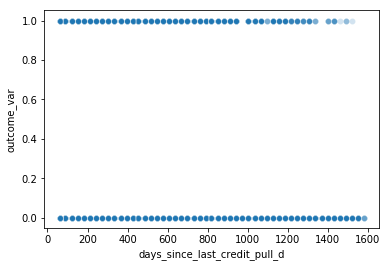

In [15]:
var_x_str = 'days_since_last_credit_pull_d'
var_y_str = 'outcome_var'
sns.scatterplot(x=var_x_str, y=var_y_str, data=lc_d_2015, alpha=0.2);
print(lc_d_2015[[var_x_str, var_y_str]].corr())

In [16]:
# More cleaning and feature engineering

convert_list = ['int_rate','revol_util']
for col in convert_list:
    new_list = []
    new_name = col + '_float'
    for i in lc_d_2015[col]:
        if col != 'revol_util':
            new_list.append(float(re.findall(r'\d+\.\d+', i)[0])/100)
        else:
            new_list.append(float(re.findall(r'\d+', i)[0])/100)
    lc_d_2015[new_name] = new_list

emp_length_int = []
for i in lc_d_2015['emp_length_2']:
    if i == 'none':
        emp_length_int.append(0)
    else:
        emp_length_int.append(int(re.findall(r'\d+', i)[0]))
lc_d_2015['emp_length_int'] = emp_length_int

earliest_cr_yrs = []
for i in lc_d_2015['earliest_cr_line']:
    earliest_cr_yrs.append(2019 - int(re.findall(r'\d+', i)[0]))
lc_d_2015['earliest_cr_yrs'] = earliest_cr_yrs

In [17]:
# Things to try:
# Use zip code to figure out if the borrower lives in urban area or not.  Also high income area or not.
# Try to figure out how to use job title (emp_title_2)
#    (maybe if the salary is really different from the avg salary for the job title, then it indicates lying)
# Use earliest_cr_line to calculate the borrower's age

# Figure out the features I want in my model
model_cols = ['outcome_var',
              #'grade',
              #'days_since_last_credit_pull_d',  <- this variable has forward looking bias
              'sub_grade',
              'loan_amnt', 'int_rate_float', 'home_ownership', 'annual_inc',
              'verification_status', 'issue_d', 'purpose', 'addr_state', 
              'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
              'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
              'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
              'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
              'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
              'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
              'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
              'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
              'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
              'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
              'mths_since_last_record_cat', 'mths_since_last_major_derog_cat', 'mths_since_rcnt_il_cat',
              'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat', 'mths_since_recent_inq_cat',
              'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

model_data = lc_d_2015[model_cols].copy()

In [18]:
# Cluster Analysis

from sklearn.cluster import KMeans

cluster_cols = ['emp_length_int', 'annual_inc', 'verification_status', 'purpose', 'home_ownership']

# Add interactions
cluster_str = cluster_cols[0]
for i in cluster_cols[1:]:
    cluster_str = cluster_str + ' + ' + i

cluster_patsy = dmatrix(cluster_str, model_data)

cluster_model = KMeans(n_clusters=5)
cluster_model.fit(cluster_patsy)
my_clusters = ['group_' + str(i) for i in cluster_model.labels_]

model_data['my_clusters'] = my_clusters

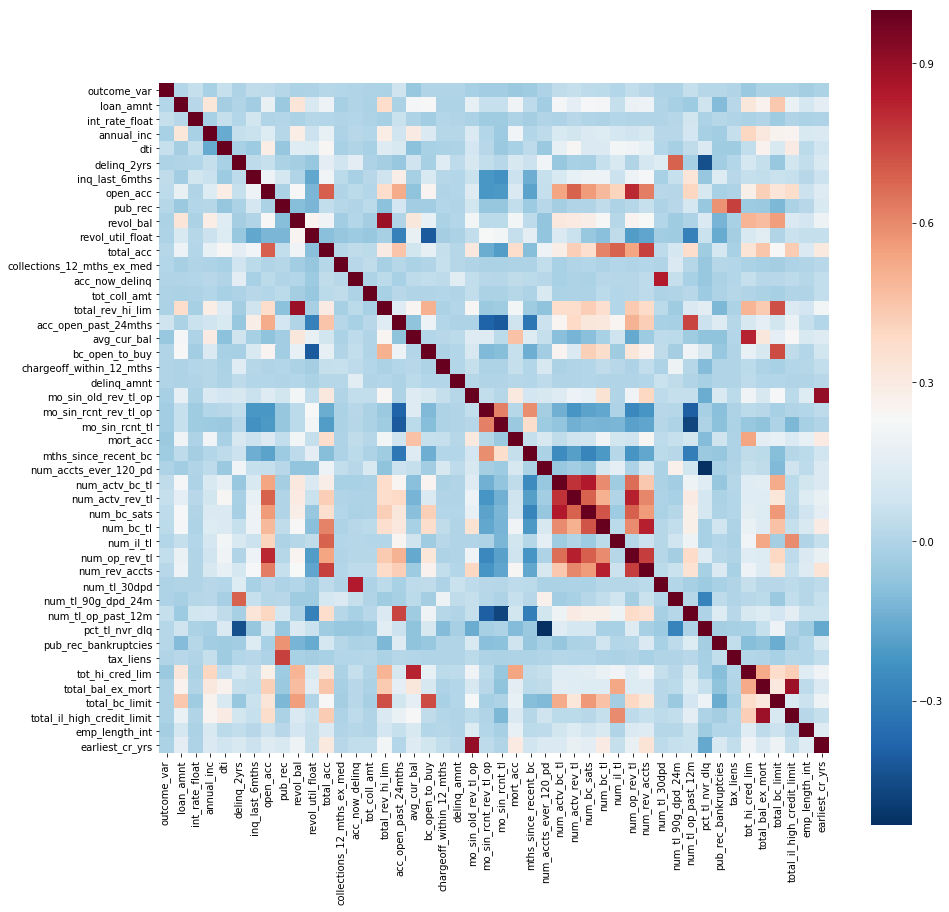

In [19]:
# Plot the correlation matrix
corrs = model_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrs, square=True, cmap="RdBu_r");
plt.savefig(fname='corr_matrix', dpi=150)

In [20]:
# Use Patsy to create my X Matrix
x_cols = ['my_clusters',
          #'grade',
          #'days_since_last_credit_pull_d',
          'sub_grade',
          'loan_amnt', 'int_rate_float', 'home_ownership', 'annual_inc',
          'verification_status', 'issue_d', 'purpose', 'addr_state', 
          'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
          'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
          'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
          'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
          'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
          'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
          'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
          'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
          'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
          'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
          'mths_since_last_record_cat', 'mths_since_last_major_derog_cat', 'mths_since_rcnt_il_cat',
          'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat', 'mths_since_recent_inq_cat',
          'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '+ loan_amnt*int_rate_float'

x_patsy = dmatrix(x_str, model_data)
print(x_patsy.shape)

(76330, 162)


In [21]:
# Shuffle and then train/test split of my variables
# from sklearn.utils import shuffle

# x_raw = x_patsy
# y_raw = model_data['outcome_var']

#x_shuffle, y_shuffle = shuffle(x_raw, y_raw)
#x_mid, x_test, y_mid, y_test = train_test_split(x_shuffle, y_shuffle, test_size=0.2, random_state=0)
#x_train, x_val, y_train, y_val = train_test_split(x_mid, y_mid, test_size=0.25, random_state=0)

# Stratified train test split
x_raw = x_patsy
y_raw = np.array(model_data['outcome_var'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_mid, x_test = x_raw[train_index,:], x_raw[test_index,:]
    y_mid, y_test = y_raw[train_index], y_raw[test_index]

sss2.get_n_splits()
for train_index, test_index in sss2.split(x_mid, y_mid):
    x_train, x_val = x_mid[train_index,:], x_mid[test_index,:]
    y_train, y_val = y_mid[train_index], y_mid[test_index]

In [22]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(x_train)
x_norm_train = scaler.transform(x_train)
x_norm_val = scaler.transform(x_val)
x_norm_test = scaler.transform(x_test)

In [23]:
# Run CV with 5 folds (knn)

# ks = [501]
# param_grid = [{'n_neighbors': ks}]

# knn = KNeighborsClassifier()
# knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
# knn_grid.fit(x_norm_train, y_train)

In [24]:
# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [25]:
# Run CV with 5 folds (SVM)

# C = [1]
# gammas = [0.001, 0.1]
# param_grid = dict(C=C, gamma=gammas)

# svm1 = svm.SVC(kernel='rbf', probability=True)
# svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
# svm_grid.fit(x_norm_train, y_train)

In [26]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(x_norm_train, y_train)

In [27]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'n_estimators': [200, 400]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
rf_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 19.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [70, 90], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 3], 'n_estimators': [200, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [28]:
# Train a neural network that doesn't crash your kernel

# n_cols = x_norm_val.shape[1]
# nn_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(n_cols,100))

# nn_model.fit(x_norm_train, y_train)

In [29]:
# Bagging

bagging_logit = BaggingClassifier(linear_model.LogisticRegression(solver='lbfgs', max_iter=10000), 
                                  n_estimators=100, max_samples=0.25, max_features=0.25)
bagging_logit.fit(x_norm_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.25,
         max_samples=0.25, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [30]:
#print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
#print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for logit: 0.6028
Best ROC_AUC for rf: 0.8061


In [31]:
#print('Best Params for knn: ', knn_grid.best_params_)
print('Best Patams for logit: ', logistic_grid.best_params_)
#print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

Best Patams for logit:  {'C': 1.0, 'penalty': 'l2'}
Best Params for rf:  {'bootstrap': True, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 400}


In [32]:
# Fit sub_grade Classifier

x_patsy_sg_train = x_norm_train[:,5:14]
x_patsy_sg_val = x_norm_val[:,5:14]
x_patsy_sg_test = x_norm_test[:,5:14]

logistic_sub_grade = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_sub_grade.fit(x_patsy_sg_train, y_train)
logistic_sub_grade.coef_

array([[ 0.02591386,  0.06931071,  0.09874365,  0.12711864, -0.08298967,
         0.01155843,  0.07525802,  0.06382471,  0.08970788]])

In [33]:
# Fit Dummy Classifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(x_norm_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

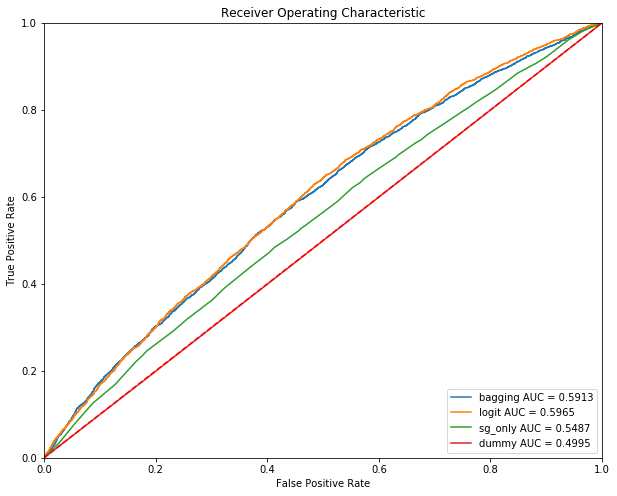

In [34]:
# ROC for all the models

# model_list = [knn_grid.best_estimator_, 
#               logistic_grid.best_estimator_, 
#               svm_grid.best_estimator_, 
#               gnb_best, 
#               rf_grid.best_estimator_,
#               'ensemble',
#               logistic_sub_grade,
#               dummy]
# model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# ROC for just the FASTEST models

# model_list = [logistic_grid.best_estimator_, 
#               gnb_best, 
#               rf_grid.best_estimator_,
#               'ensemble',
#               logistic_sub_grade,
#               dummy]
# model_name = ['logit', 'n_bayes', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# ROC for testing

model_list = [bagging_logit,
              logistic_grid.best_estimator_,
              logistic_sub_grade,
              dummy]
model_name = ['bagging', 'logit', 'sg_only', 'dummy']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.60
        w2 = 0.30
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(x_norm_val)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(x_norm_val)[:,1]
                  + (1-w1-w2)*gnb_best.predict_proba(x_norm_val)[:,1])
        
    elif model == logistic_sub_grade:
        y_pred = list(model.predict_proba(x_patsy_sg_val)[:,1])
    else:
        y_pred = list(model.predict_proba(x_norm_val)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
# Examine the correlation of the model errors

#knn_error = y_train - knn_grid.predict_proba(x_norm_train)[:,1]
logit_error = y_train - logistic_grid.predict_proba(x_norm_train)[:,1]
#svm_error = y_train - svm_grid.predict_proba(x_norm_train)[:,1]
gnb_error = y_train - gnb_best.predict_proba(x_norm_train)[:,1]
rf_error = y_train - rf_grid.predict_proba(x_norm_train)[:,1]

error_df = pd.DataFrame()
#error_df['knn'] = knn_error
error_df['logit'] = logit_error
#error_df['svm'] = svm_error
error_df['gnb'] = gnb_error
error_df['rand_forest'] = rf_error

error_df.corr()

,logit,gnb,rand_forest
logit,1.000000,0.905456,0.985173
gnb,0.905456,1.000000,0.891303
rand_forest,0.985173,0.891303,1.000000


In [36]:
# Try to boost performance using PCA

In [37]:
# Try to boost performance using Ensemble

In [38]:
# Set cutoff by trading off between recall and precision (confusion matrix)
# conf_mat = metrics.confusion_matrix(y_val, y_pred)

In [39]:
# For backtest, randomly pick baskets of 500 loans and compare their performance with your model picked 500 loans